In [47]:
import numpy as np
import sklearn
import matplotlib
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, norm



def pprint(x, x_name):
    if len(x.shape) > 1:
        print(f"{x_name} =\n{x}")
    else:
        print(f"{x_name} = {x}")

### Dataset = [Optical recognition of handwritten digits dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset)
Scikit-learn (usually abbreviated sklearn) provides a collection of standard datasets that are suitable for testing a classification algorithm (see https://scikit-learn.org/stable/datasets.html
for a list of the available datasets and usage instructions). In this exercise, we want to recognize handwritten digits, which is a typical machine learning application. The dataset digits consists of
1797 small images with one digit per image.
Load the dataset from sklearn and extract the data:

# 1. Exploring the Data

In [2]:
digits = load_digits()
print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


Note that data is flattened (1-dimensional) version of images. What is the size of these images (the numpy attribute shape might come in handy)? Visualize one image of a 3 using the imshow function from `matplotlib.pyplot`, trying the two interpolation methods in the code:

In [3]:
pprint(data, "data")

data =
[[ 0.  0.  5. ...  0.  0.  0.]
 [ 0.  0.  0. ... 10.  0.  0.]
 [ 0.  0.  0. ... 16.  9.  0.]
 ...
 [ 0.  0.  1. ...  6.  0.  0.]
 [ 0.  0.  2. ... 12.  0.  0.]
 [ 0.  0. 10. ... 12.  1.  0.]]


### What is the size of the image?

In [4]:
data.shape

(1797, 64)

The data is a flattened vector of the 8x8 pixel 16 bit images, hence the length of 64.

In [5]:
target

array([0, 1, 2, ..., 8, 9, 8])

In [6]:
np.where(target == 3)[0][0]

3

In [7]:
img = data[[3]]

assert len(img.shape) == 2

pprint(img, "img")

img =
[[ 0.  0.  7. 15. 13.  1.  0.  0.  0.  8. 13.  6. 15.  4.  0.  0.  0.  2.
   1. 13. 13.  0.  0.  0.  0.  0.  2. 15. 11.  1.  0.  0.  0.  0.  0.  1.
  12. 12.  1.  0.  0.  0.  0.  0.  1. 10.  8.  0.  0.  0.  8.  4.  5. 14.
   9.  0.  0.  0.  7. 13. 13.  9.  0.  0.]]


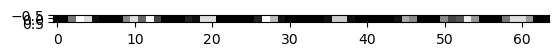

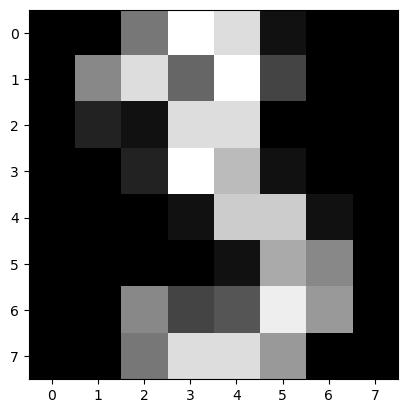

In [8]:
plt.figure()
plt.gray()
plt.imshow(img, interpolation = "nearest")
plt.show()

plt.figure()
plt.gray()
plt.imshow(np.reshape(img, (8,8)) , interpolation = "nearest")
plt.show()

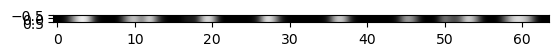

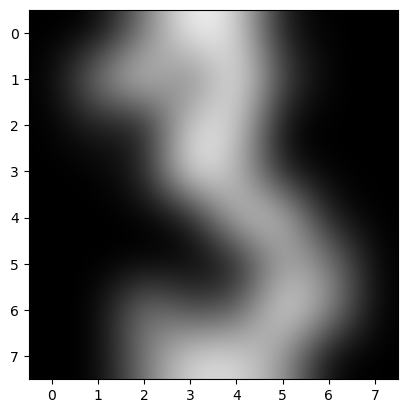

In [9]:
plt.figure()
plt.gray()
plt.imshow(img , interpolation = "bicubic")
plt.show()

plt.figure()
plt.gray()
plt.imshow(np.reshape(img, (8,8)) , interpolation = "bicubic")
plt.show()

We will only work with digits "3" and "9" to get a two-class problem. Please filter the dataset such that only these two digits are left. Split this filtered dataset in a training and a test set (#train/#test = 3/2). Sklearn provides a convenient function to separate the data into a training and a test set:

In [10]:
from sklearn import model_selection
X_filtered = data[np.in1d(target, [3,9])]
y_filtered = target[np.in1d(target, [3,9])]

X_train , X_test , y_train , y_test = \
    model_selection.train_test_split(X_filtered, y_filtered, test_size = 0.4, random_state = 0)

# 2. Hand-crafted classifier

To better appreciate the achievements of machine learning, we will start with a hand-crafted classifier

## 2.1 Feature construction

To facilitate visualization, you should construct a 2-dimensional feature space with any formula over the 64 original pixels you can come up with. You may, for example, choose two pixels that seem to have a big influence for the distinction between 3's and 9's. To identify suitable pixels, you may want to look at the average images for the two classes - pixels that tend to be bright in one class and dark in the other are good candidates. You can also use some clever linear or non-linear combination of multiple pixels into 2 features, for example: $\hat{f}_1 = 0.3 \cdot f_{23} + 42 \cdot \frac{f_13}{f_64}$ and $\hat{f}_2 = f_{33} - f_{62}$. Of course, the quality of your features determines the achievable error and therefore is a limiting factor for the quality of your predictions. Your dimension reduction procedure should be callable through a function `features2d`:
$\text{features = features2d(x)}$
where x is a #instances × 64 matrix and features has shape #instances × 2.

IDF: Create a dimentionality reduction function to reduce the information found in 64 pixels (features) to 2 arbirtrarily set features

In [11]:
def features2d(x):
    """
    - Input: np.array | shape = (N, 64)
    - Output: np.array | shape = (N, 2)
    - Algorithm:
        Computes the mean of the upper half and the lower half of the array
    """

    f1 = np.mean(x[:, 0:32], axis = 1)
    f2 = np.mean(x[:, 32:64], axis = 1)

    dim_red = np.stack([f1, f2], axis = 1)

    return dim_red

In [12]:
X_train_red = features2d(X_train)
X_test_red = features2d(X_test)

## 2.2 Scatterplot

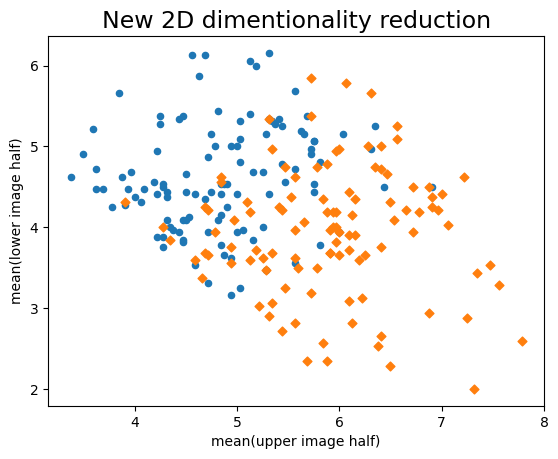

In [13]:
plt.figure()
plt.scatter(X_train_red[y_train == 3][:, 0], X_train_red[y_train == 3][:, 1], s=20)
plt.scatter(X_train_red[y_train == 9][:, 0], X_train_red[y_train == 9][:, 1], s=20, marker="D")
plt.title("New 2D dimentionality reduction", fontsize=17)
plt.xlabel("mean(upper image half)")
plt.ylabel("mean(lower image half)")
plt.show()

## 2.3 Decision rule

First define a very simple decision rule: Find the mean of the 2D feature vectors of each class in the training set and assign each test instance to the label of the nearest mean. The decision boundary
of this method is the bisector between the two means. The signature of the function is supposed to look like this:
$$\text{predicted_labels = nearest_mean(training_features, training_labels, test_features)}$$
where `training_features` and `test_features` are the outputs of `features2d()` for training and test data respectively. Compute and report the training and test errors of the classifier (i.e. the ratio $\frac{#FP + #FN}{N}$ on the respective dataset).

If your features are very informative, this classifier may already have good performance. Otherwise, you can define a more sophisticated decision boundary by picking good β and b in the formula $ybi = sign(xi · β + b)$. If this is still not satisfactory, improve your features. Again compute and report the test error of your formula.

IDF: Create a decision rule based on class means of each feature. The decision is made based on the closes mean (bisecting function, perpendicular bisector in 2D)

In [14]:
def bisector(point1, point2):
    """
    Takes two vectors and finds the bisecting function
    - point1: np.array, .shape = (2)
    - point1: np.array, .shape = (2)
    - return: list, len = 2

    - What is a bisector? https://www.youtube.com/watch?v=9SSVIa2npK8
    The bisector is the function that goes through the midpoint between two datapoints and (2) has a perpendicular slope to the vector between the datapoints
    """


    # Find the midpoint of the two vectors by taking the average of the two points
    midpoint = (point1 + point2) / 2

    # Find the slope of the vector
    m = point1 - point2
    m = m[1] / m[0]

    # Invert the slope
    m_i = -1 / m

    # Find the b coefficient in y = mx + b
    b = midpoint[1] - (m_i * midpoint[0])

    return [m_i, b]

In [15]:
def classifier(X, m, b, label1, label2):
    """
    Classifies a response dataset based on a bisecting function
    - X: np.array, .shape = 2
    - m: slope,
    - b: b coefficient
    - label1: int
    - label2: int
    - return: np.array, .shape = 1
    """
    return np.where(X[:,1] > (X[:,0] * m + b), label1, label2).astype(int)

In [16]:
def nearest_mean(X, y, y_2_pred):
    """
    - param X_train: train set , type == np.array() , .shape == (N_train, 2)
    - y_train: test set | type == np.array() , .shape == (N_test, 2)
    - param X_test: train labels, .shape = (N_test)
    - return: predicted class, np.array, .shape = (N_test)
    """
    means_train = np.array(
        [np.mean(X[y == 3], axis=0),
         np.mean(X[y == 9], axis=0)]
    )

    m, b = bisector(means_train[0], means_train[1])

    pred = classifier(y_2_pred, m, b, label1=3, label2=9)

    return pred

In [17]:
y_test_pred = nearest_mean(X=X_train_red, y=y_train, y_2_pred=X_test_red)

pprint(y_test_pred, "y_test_pred")

y_test_pred = [9 9 9 3 9 9 3 3 3 3 3 9 9 3 9 9 3 3 9 9 9 9 3 3 3 3 3 9 9 3 9 9 9 3 9 3 9
 3 3 3 3 9 3 3 3 3 3 9 3 3 3 9 9 9 9 9 9 3 9 9 3 3 3 3 9 9 3 9 9 9 9 3 9 3
 9 9 9 3 9 9 3 9 3 9 9 3 9 3 9 9 3 9 9 9 9 9 9 9 3 9 3 3 3 3 9 9 3 3 3 9 3
 9 9 9 3 3 9 9 3 9 9 9 3 3 9 3 9 9 3 9 9 9 3 9 9 3 3 9 3 9 9 3 9 3 9 9]


In [18]:
y_train_pred = nearest_mean(X=X_train_red, y=y_train, y_2_pred=X_train_red)

pprint(y_train_pred, "y_train_pred")

y_train_pred = [9 9 9 3 9 3 3 3 9 9 9 3 3 3 9 9 3 9 9 3 9 3 9 9 3 3 9 9 9 3 9 9 3 9 9 3 3
 3 3 3 3 3 9 9 3 3 9 9 3 9 3 9 9 9 9 3 3 9 3 3 9 9 3 9 3 3 9 3 3 3 3 9 9 3
 9 9 9 3 3 9 3 3 3 3 3 9 3 3 3 9 3 9 9 9 9 9 9 3 9 3 3 3 3 3 3 9 3 3 9 9 9
 9 9 9 9 3 3 9 3 9 3 9 3 3 3 3 3 3 9 9 3 9 3 9 3 3 9 9 9 3 3 3 9 9 3 9 3 3
 3 3 3 3 3 3 9 9 9 9 9 9 3 3 3 9 3 3 9 9 9 3 3 3 3 3 3 9 3 9 9 9 9 3 9 3 9
 3 3 3 9 3 9 3 9 9 3 3 9 3 3 3 3 9 3 9 3 9 9 3 9 3 3 3 3 3 3 9 3]


**Test error**

In [19]:
np.sum((y_test_pred - y_test) != 0) / len(y_test_pred)

0.21232876712328766

**Train error**

In [20]:
np.sum((y_train_pred - y_train) != 0) / len(y_train_pred)

0.17972350230414746

IDF: Training error is overconfident

## 2.4 Visualize the decision regions

An image of the decision regions can be quite helpful for analyzing classier performance. The simplest way to do this is to create a grid (i.e. an image) where each pixel position represents
a feature coordinate, and the pixel is colored with the corresponding predicted class label. Since you created the features on your own, you must nd a sensible transformation (i.e translation and
scaling) from feature coordinates to grid coordinates so that your image covers the interesting part of the feature domain. A 200×200 grid provides sucient resolution. Plot this image to visualize the
decision regions. Overlay the plot with two markers for the two class means and with a scatterplot of the test data, marked according to their ground truth labels as in task 2.2. Consult the matplotlib
documentation to nd out how several layers of information can be overlayed in the same plot. Plot the decision boundary of the two models from the previous subtask.

IDF: Create decision rule explicitly

In [21]:
means_train = np.array(
        [np.mean(X_train_red[y_train == 3], axis=0),
         np.mean(X_train_red[y_train == 9], axis=0)]
    )

m, b = bisector(means_train[0], means_train[1])

IDF: Create coordinate grid and "discrete" values for each coordinate

In [22]:
x = np.linspace(3, 9, 400) # x-limits and resolution arbitrarily set after plotting and adjusting
y = np.linspace(1, 7, 400) # x-limits and resolution arbitrarily set after plotting and adjusting

X, Y = np.meshgrid(x, y)

pos = np.dstack((X, Y))

L = np.zeros(X.shape)

for x in range(0, X.shape[0]):
    for y in range(0, X.shape[1]):
        L[x, y] = classifier(np.array([[X[x,y], Y[x,y]]]), m, b, label1=3, label2=9)



IDF: Plot

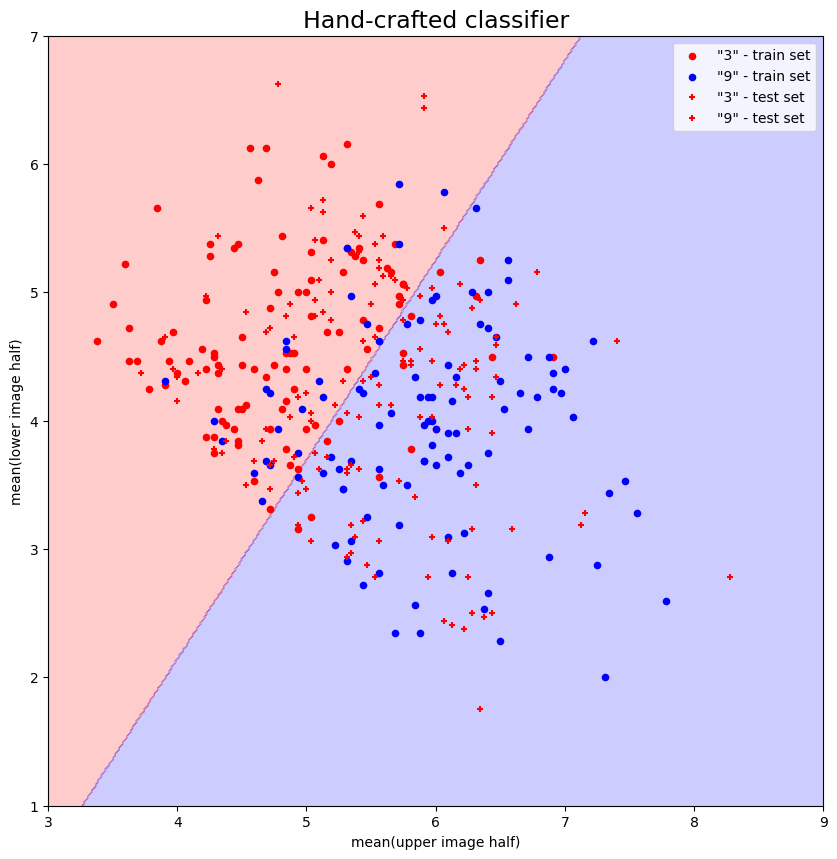

In [23]:
plt.figure(figsize=(10,10))

plt.contourf(X, Y, L, levels=2, alpha=0.2, colors=["red","blue"])#, shading="auto")
plt.scatter(X_train_red[y_train == 3][:, 0], X_train_red[y_train == 3][:, 1], s=20, c="red", label="\"3\" - train set")
plt.scatter(X_train_red[y_train == 9][:, 0], X_train_red[y_train == 9][:, 1], s=20, c="blue", label="\"9\" - train set")
plt.scatter(X_test_red[y_test == 3][:, 0], X_test_red[y_test == 3][:, 1], s=20, c="red", marker="+", label="\"3\" - test set")
plt.scatter(X_test_red[y_test == 9][:, 0], X_test_red[y_test == 9][:, 1], s=20, c="red", marker="+", label="\"9\" - test set")

plt.legend()

plt.title("Hand-crafted classifier", fontsize=17)
plt.xlabel("mean(upper image half)")
plt.ylabel("mean(lower image half)")
plt.show()

# 3 LDA

## 3.1 Implement LDA training

Implement the function:
`mu, covmat, p = fit_lda(training_features, training_labels)`
that accepts a N × D matrix training_features and a N -dimensional vector raining_labels, where N is the total number of training instances used. Your code should work for arbitrary values of D , so that we can apply it to your features from task 2 as well as to the full vector of 64 pixels. Recall that the features xj are the rows of matrix training_features. Use the algorithm that fits the cluster means and covariance matrix as explained in the lecture:

[...]

The output of fit_lda should be the 2 × D matrix mu whose rows are the two class means, the D × D matrix covmat containing the covariance and the vector p containing the two priors. Apply the fir function to your feature data from task 2 and to the full pixel vector.
We shouldn't use all 64 pixel-dimensions though, as there are some 'dead' ixels i.e. they take the value of zero in every image. Filter them out rst by calculating the variance of each pixel over all images (use numpy.var()) and asking out the pixels with a variance smaller than 0.001.

In [24]:
def filter_dead(data):
    """
    Remove the 'dead' pixels with variance < 0.001
    """
    variance_threshold = 0.001
    feature_variances = np.var(data, axis=0)#variance
    valid_indices = np.where(feature_variances >= variance_threshold)[0]
    filtered_features = data[:, valid_indices]

    return filtered_features

In [25]:
def fit_lda(training_features, training_labels):
    '''
    training_features: an N x D matrix, where N is the total number of instances
    training_labels: N-dimentional vector
    '''

    # Filter for labels 3 and 9
    class_3_features = training_features[training_labels == 3] # 3
    class_9_features = training_features[training_labels == 9] # 9

    # Calculate class means
    mu_3 = np.mean(class_3_features, axis=0)
    mu_9 = np.mean(class_9_features, axis=0)

    # Calculate the covariance matrix
    covmat_3 = np.cov(class_3_features, rowvar=False)
    covmat_9 = np.cov(class_9_features, rowvar=False)

    # Calculate the pooled covariance matrix
    N_3 = class_3_features.shape[0]
    N_9 = class_9_features.shape[0]
    covmat = (covmat_3 * (N_3) + covmat_9 * (N_9)) / (N_3 + N_9)

    # Calculate the priors
    p = np.array([N_3, N_9]) / (N_3 + N_9)

    # Combine class means into a matrix
    mu = np.vstack((mu_3, mu_9))

    return mu, covmat, p

In [26]:
# Apply LDA to full feature space
x_filter_train=filter_dead(X_train)
x_filter_test=filter_dead(X_test)

mu_1, covmat_1, p_1 = fit_lda(training_features =x_filter_train, training_labels =y_train)
mu_2, covmat_2, p_2 = fit_lda(training_features =x_filter_test, training_labels =y_test)

print('mu_1', mu_1.shape)
print('covmat_1', covmat_1.shape)
print('p_1', p_1.shape)


mu_1 (2, 53)
covmat_1 (53, 53)
p_1 (2,)


In [27]:
# Apply LDA to reduced 2-dimensional feature space from exercise 2
x_filter_train_2d=filter_dead(X_train_red)
x_filter_test_2d=filter_dead(X_test_red)

mu_1_2d, covmat_1_2d, p_1_2d = fit_lda(training_features =x_filter_train_2d, training_labels =y_train)
mu_2_2d, covmat_2_2d, p_2_2d = fit_lda(training_features =x_filter_test_2d, training_labels =y_test)

print('mu_1_2d', mu_1_2d.shape)
print('covmat_1_2d', covmat_1_2d.shape)
print('p_1_2d', p_1_2d.shape)

mu_1_2d (2, 2)
covmat_1_2d (2, 2)
p_1_2d (2,)


## 3.2 Implement LDA prediction

In [28]:
def predict_lda(mu, covmat, p, test_features):
    '''
    mu: the class means matrix
    covmat: the pooled covariance matrix
    p: the priors vector
    '''
    # Compute the inverse of the covariance matrix
    covmat_inv = np.linalg.inv(covmat)

    # Calculate the coefficients for the decision rule
    beta = covmat_inv.dot((mu[1] - mu[0]).T)
    b = -0.5 * (mu[1] + mu[0]).dot(beta) + np.log(p[1] / p[0])

    # Apply the decision rule to make predictions
    scores = test_features.dot(beta) + b
    #predicted_labels = np.sign(scores)

    return scores

In [29]:
# FULL FEATURE SPACE
# Apply the predict_lda function to training and test data
train_predicted_labels = predict_lda(mu_1, covmat_1, p_1, x_filter_train)
test_predicted_labels = predict_lda(mu_2, covmat_2, p_2, x_filter_test)

# Create label arrays where -1 is for 3 and 1 for 9
y_train_label = np.where(y_train == 3, -1, y_train)
y_train_label = np.where(y_train == 9, 1, y_train)
y_test_label = np.where(y_test == 3, -1, y_test)
y_test_label = np.where(y_test == 9, 1, y_test)

# Compute the training and test error rates
train_error_rate = np.mean(np.sign(train_predicted_labels) != y_train_label)
test_error_rate = np.mean(np.sign(test_predicted_labels) != y_test_label)

print("Training error rate:", train_error_rate)
print("Test error rate:", test_error_rate)

Training error rate: 0.5161290322580645
Test error rate: 0.4931506849315068


In [30]:
# 2D FEATURE SPACE
# Apply the predict_lda function to training and test data
train_predicted_labels_2d = predict_lda(mu_1_2d, covmat_1_2d, p_1_2d, x_filter_train_2d)
test_predicted_labels_2d = predict_lda(mu_2_2d, covmat_2_2d, p_2_2d, x_filter_test_2d)

# Create label arrays where -1 is for 3 and 1 for 9
y_train_label_2d = np.where(y_train == 3, -1, y_train)
y_train_label_2d = np.where(y_train == 9, 1, y_train)
y_test_label_2d = np.where(y_test == 3, -1, y_test)
y_test_label_2d = np.where(y_test == 9, 1, y_test)

# Compute the training and test error rates
train_error_rate_2d = np.mean(np.sign(train_predicted_labels_2d) != y_train_label_2d)
test_error_rate_2d = np.mean(np.sign(test_predicted_labels_2d) != y_test_label_2d)

print("Training error rate (2d):", train_error_rate_2d)
print("Test error rate (2d):", test_error_rate_2d)

Training error rate (2d): 0.6221198156682027
Test error rate (2d): 0.5958904109589042


IDF: Off script. The following inclusion of gaussian naive bayes improves our implementation of LDA

In [31]:
from sklearn.naive_bayes import GaussianNB

#expand matrix
train_predicted_labels1 = np.expand_dims(train_predicted_labels,1)
test_predicted_labels1 = np.expand_dims(test_predicted_labels,1)

LDA=[]
#
bc =  GaussianNB()
bc.fit(train_predicted_labels1,y_train_label)


for i in range(y_test_label.shape[0]):
    LDA.append(bc.score(test_predicted_labels1,y_test_label))


print('LDA accuracy:',np.mean(LDA))


LDA accuracy: 1.0


## 3.3. Visualization

Create a grid for the 2-dimensional LDA decision regions and plot it as in task 2.4. Overlay this plot with a scatter plot of the training data. Then add another overlay that visualizes the cluster shape of the two Gaussian distributions in terms of representative isocontours (i.e. ellipses). Check out the documentation for matplotlib's contour function to learn how to do this. Furthermore, perform an eigenvalue/eigenvector decomposition of the covariance matrix using
numpy.linalg.eig(). Recall that the eigenvectors indicate the directions of the principal cluster axes, and the eigenvalues' square roots are the corresponding standard deviations, i.e. they indicate the cluster radii along each axis. Add another overlay to your plot that draws these axes (centered at the cluster mean) in form of lines whose length equals the standard deviation. Use this plot to comment on the quality of the LDA results separately on both the training and test data.

IDF: Define plot grid coordinate

In [39]:
x_lim = np.array([3, 9])
x_res = 400
y_lim = np.array([1, 7])
y_res = 400


x_coor = np.round(np.linspace(x_lim[0], x_lim[1], x_res), decimals=2) # x-limits and resolution arbitrarily set after plotting and adjusting
y_coor = np.round(np.linspace(y_lim[0], y_lim[1], y_res), decimals=2) # y-limits and resolution arbitrarily set after plotting and adjusting

X, Y = np.meshgrid(x_coor, y_coor)

pos = np.dstack((X, Y))

IDF: Create LDA predictions for plot coordinates

In [33]:
X_4plot = np.empty((0, 2))

for x in x_coor:
    for y in y_coor:
        X_4plot = np.vstack((X_4plot, np.array([x, y])))

# Apply the predict_lda function to training and test data
train_predicted_labels_coor = np.sign(predict_lda(mu_1_2d, covmat_1_2d, p_1_2d, X_4plot))

# Create the decision boundary coordinate variable L
L = np.zeros((x_res, y_res))

for x in range(x_res):
    for y in range(y_res):
        index = (x * x_res) + y
        L[x, y] = train_predicted_labels_coor[index]


IDF: create gaussian distr regions of respective label cluster

In [56]:
Z3 = multivariate_normal.pdf(pos, mean=[mu_1_2d[0, 0], mu_1_2d[0, 1]])
Z9 = multivariate_normal.pdf(pos, mean=[mu_1_2d[1, 0], mu_1_2d[1, 1]])

IDF: Plot

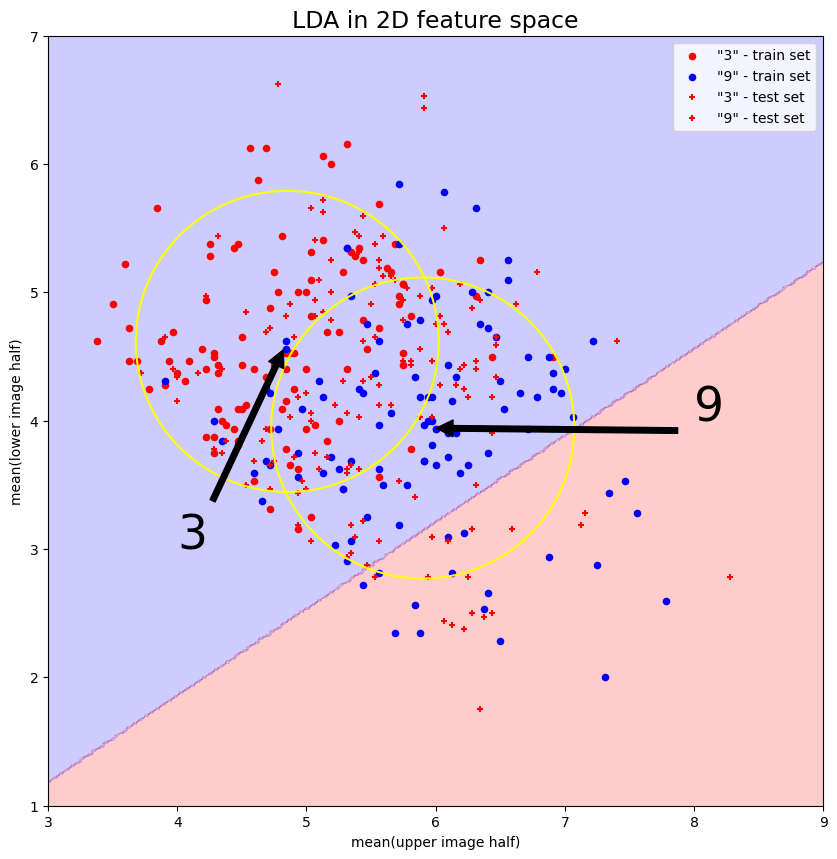

In [74]:
plt.figure(figsize=(10,10))

plt.contour(X, Y, Z3, levels=1, colors=["red","yellow"])#, shading="auto")
plt.contour(X, Y, Z9, levels=1, colors=["red","yellow"])#, shading="auto")
plt.contourf(X, Y, L, levels=2, alpha=0.2, colors=["red","blue"])#, shading="auto")
plt.scatter(X_train_red[y_train == 3][:, 0], X_train_red[y_train == 3][:, 1], s=20, c="red", label="\"3\" - train set")
plt.scatter(X_train_red[y_train == 9][:, 0], X_train_red[y_train == 9][:, 1], s=20, c="blue", label="\"9\" - train set")
plt.scatter(X_test_red[y_test == 3][:, 0], X_test_red[y_test == 3][:, 1], s=20, c="red", marker="+", label="\"3\" - test set")
plt.scatter(X_test_red[y_test == 9][:, 0], X_test_red[y_test == 9][:, 1], s=20, c="red", marker="+", label="\"9\" - test set")

plt.legend()

plt.title("LDA in 2D feature space", fontsize=17)
plt.xlabel("mean(upper image half)")
plt.ylabel("mean(lower image half)")

plt.annotate(
    "3",
    xy=[mu_1_2d[0, 0], mu_1_2d[0, 1]],
    xytext=([4,3]),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=34,
)

plt.annotate(
    "9",
    xy=[mu_1_2d[1, 0], mu_1_2d[1, 1]],
    xytext=([8,4]),
    arrowprops=dict(facecolor="black", shrink=0.05),
    fontsize=34,
)

plt.show()

In [36]:
#decomposition
n_components=2
eigenvalues, eigenvectors = np.linalg.eig(covmat_1)
# -> eigenvector v = [:,i] column vector, transpose for easier calculations
# sort eigenvalues high to low
eigenvectors = eigenvectors.T
idxs = np.argsort(abs(eigenvalues))[::-1]
eigenvalues = eigenvalues[idxs]
eigenvectors = eigenvectors[idxs]
# store first n eigenvectors
linear_discriminants = eigenvectors[0:n_components]


## 3.4 Quantitative performance evaluation

In [37]:
#cross_validation

#from sklearn.model_selection import cross_val_score
#scores = cross_val_score(predict_lda(mu_2, covmat_2, p_2, x_filter_test), x_test, y_test, cv=5)
#print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
#5折交叉验证

k = 10
mun_validation_samples = x_filter_train.shape[0] // k

print(mun_validation_samples)
#np.random.shuffle(x_Train_normaliza)  #

validation_score = []
sum=0
import random
for fold in range(k):

    validation_data = x_filter_train[mun_validation_samples*fold:mun_validation_samples*(fold+1),:]
    validation_data_label=y_train[mun_validation_samples*fold:mun_validation_samples*(fold+1)]
    a=x_filter_train[:mun_validation_samples * fold,:]
    b=x_filter_train[mun_validation_samples * (fold+1):,:]
    training_data=np.append(a,b,axis=0)
    c=y_train[:mun_validation_samples*fold]
    d= y_train[mun_validation_samples*(fold+1):]
    training_label=np.append(c,d,axis=0)
    #training_label=y_Trainonehot[:mun_validation_samples*fold] + y_Trainonehot[mun_validation_samples*(fold+1):]

    #打散数据
    index = [i for i in range(len(training_data))]
    random.shuffle(index)
    data = training_data[index]
    label = training_label[index]
    #开始训练
    mu_1, covmat_1, p_1 = fit_lda(training_features =data, training_labels =label)
    # Apply the predict_lda function to training and test data
    train_predicted_labels = predict_lda(mu_1, covmat_1, p_1, x_filter_train)

    # Create label arrays where -1 is for 3 and 1 for 9
    y_train_label = np.where(y_train == 3, -1, y_train)
    y_train_label = np.where(y_train == 9, 1, y_train)


    # Compute the training and test error rates
    #train_error_rate = np.mean(train_predicted_labels != y_train_label)
    #test_error_rate = np.mean(test_predicted_labels != y_test_label)

    #expand matrix
    train_predicted_labels1 = np.expand_dims(train_predicted_labels,1)

    #model.train(training_data)
    LDA=[]
    bc =  GaussianNB()
    bc.fit(train_predicted_labels1,y_train_label)
    for i in range(y_test_label.shape[0]):
        LDA.append(bc.score(test_predicted_labels1,y_test_label))

    #validation_score = model.evaluate(validation_data,validation_data_label)
    #validation_score_accuracy=validation_score[1]
    sum=sum+np.mean(LDA)
    print('validation_score=',np.mean(LDA))

validation_score_average=sum/k
print('validation_score_average',validation_score_average)

21
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score= 1.0
validation_score_average 1.0


In [38]:
##sklearn package
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd

from sklearn.naive_bayes import GaussianNB

#读取数据
df = x_train
output = y_train

lda = LinearDiscriminantAnalysis(n_components=2)


#方法1，调用时直接指定n_components的大小，然后转换。
#LDA = LinearDiscriminantAnalysis(n_components=2)

#LDA_1_2 = LDA.fit_transform(df,output)

x_train_lda = lda.fit_transform(x_train, y_train) # LDA是有监督方法，需要用到标签

x_test_lda = lda.fit_transform(x_test, y_test) # 预测时候特征向量正负问题，乘-1反转镜像

#res=LDA.predict(x_test)

LDA=[]
#
bc =  GaussianNB()
bc.fit(x_train_lda,y_train)
for i in range(x_train.shape[0]):
    LDA.append(bc.score(x_test_lda,y_test))


print('LDA:',np.mean(LDA))


ModuleNotFoundError: No module named 'pandas'

# 4. SVM

In [ ]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=1e-3, lambda_param=1e-2, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def _init_weights_bias(self, X):
        n_features = X.shape[1]
        self.w = np.zeros(n_features)
        self.b = 0

    def _get_cls_map(self, y):
        return np.where(y <= 0, -1, 1)

    def _satisfy_constraint(self, x, idx):
        linear_model = np.dot(x, self.w) + self.b
        return self.cls_map[idx] * linear_model >= 1

    def _get_gradients(self, constrain, x, idx):
        if constrain:
            dw = self.lambda_param * self.w
            db = 0
            return dw, db

        dw = self.lambda_param * self.w - np.dot(self.cls_map[idx], x)
        db = - self.cls_map[idx]
        return dw, db

    def _update_weights_bias(self, dw, db):
        self.w -= self.lr * dw
        self.b -= self.lr * db

    def fit(self, X, y):
        self._init_weights_bias(X)
        self.cls_map = self._get_cls_map(y)

        for _ in range(self.n_iters):
            for idx, x in enumerate(X):
                constrain = self._satisfy_constraint(x, idx)
                dw, db = self._get_gradients(constrain, x, idx)
                self._update_weights_bias(dw, db)

    def predict(self, X):
        estimate = np.dot(X, self.w) + self.b
        prediction = np.sign(estimate)
        return np.where(prediction == -1, 0, 1)


In [ ]:
clf = SVM(n_iters=1000)

# Create label arrays where -1 is for 3 and 1 for 9
y_train_label = np.where(y_train == 3, -1, y_train)
y_train_label = np.where(y_train == 9, 1, y_train)
y_test_label = np.where(y_test == 3, -1, y_test)
y_test_label = np.where(y_test == 9, 1, y_test)

clf.fit(x_train, y_train_label)
predictions = clf.predict(x_test)



def accuracy(y_true, y_pred):
    accuracy = np.sum(y_true==y_pred) / len(y_true)
    return accuracy

print("SVM Accuracy: ", accuracy(y_test_label, predictions))

In [ ]:
#SVM package

In [ ]:
import pandas as pd
import numpy as np
import winreg
from sklearn.model_selection import train_test_split#划分数据集与测试集
from sklearn import svm#导入算法模块
from sklearn.metrics import accuracy_score#导入评分模块

In [ ]:
svm_linear=svm.SVC(C=10,kernel="linear",decision_function_shape="ovr")#参数部分会在下面进行讲解
svm_linear.fit(x_train,y_train)
print("SVM-train-accuracy："+str(accuracy_score(y_train,svm_linear.predict(x_train))))
print("SVM-test-accuracy："+str(accuracy_score(y_test,svm_linear.predict(x_test))))